# **DOMINOS PREDICTIVE PURCHASE ORDER SYSTEM**

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error as mape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings("ignore")   # Suppressing the warnings

c:\Users\DELL\anaconda3\envs\py8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load pizza sales and ingredients datasets

Sales_df = pd.read_excel("data/Pizza_Sale.xlsx")
Ingredients_df = pd.read_excel("data/Pizza_ingredients.xlsx")

## Understanding the Data

* On average, a Domino's store in US sells about 400 pizzas per day. Domino's US sells over 4 million pizzas per month.

### Dataset Overview:
* Pizza_Sale.csv with 48,620 rows and 12 columns.
* Pizza_Ingredients.csv with 518 rows and 4 columns.

## **1. DATA PREPROCESSING**

## i) Pizza Sales dataset

In [3]:
Sales_df.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01 00:00:00,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01 00:00:00,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [4]:
Sales_df.shape

(48620, 12)

In [5]:
Sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB


In [6]:
Sales_df.describe()

,pizza_id,order_id,quantity,unit_price,total_price
count,48620.000000,48620.000000,48620.000000,48620.000000,48613.000000
mean,24310.500000,10701.479761,1.019622,16.494132,16.821494
std,14035.529381,6180.119770,0.143077,3.621789,4.437520
min,1.000000,1.000000,1.000000,9.750000,9.750000
25%,12155.750000,5337.000000,1.000000,12.750000,12.750000
50%,24310.500000,10682.500000,1.000000,16.500000,16.500000
75%,36465.250000,16100.000000,1.000000,20.250000,20.500000
max,48620.000000,21350.000000,4.000000,35.950000,83.000000


### **Handling Missing or Null Values for Pizza Sales**

In [7]:
Sales_df.isnull().sum()

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64

In [8]:
# Check for missing values in unit_price and quantity

print(Sales_df[['unit_price', 'quantity']].isnull().sum())

unit_price    0
quantity      0
dtype: int64


In [9]:
# Fill total_price based on unit_price and quantity (since unit price and quantity dont have null values)

Sales_df['total_price'] = Sales_df['total_price'].fillna(Sales_df['unit_price'] * Sales_df['quantity'])

In [10]:
# Missing Pizza categories

Sales_df[Sales_df['pizza_category'].isna()].head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
426,427,181,mexicana_l,1,2015-03-01 00:00:00,18:49:32,20.25,20.25,L,NaN,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
427,428,182,brie_carre_s,1,2015-03-01 00:00:00,18:50:10,23.65,23.65,S,NaN,"Brie Carre Cheese, Prosciutto, Caramelized Oni...",The Brie Carre Pizza
428,429,182,peppr_salami_l,1,2015-03-01 00:00:00,18:50:10,20.75,20.75,L,NaN,"Genoa Salami, Capocollo, Pepperoni, Tomatoes, ...",The Pepper Salami Pizza
429,430,183,napolitana_m,1,2015-03-01 00:00:00,18:54:55,16.00,16.00,M,NaN,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza
430,431,183,spin_pesto_l,1,2015-03-01 00:00:00,18:54:55,20.75,20.75,L,NaN,"Spinach, Artichokes, Tomatoes, Sun-dried Tomat...",The Spinach Pesto Pizza


In [11]:
# Counts and sorts the frequency of unique values

Sales_df['pizza_category'].value_counts()

pizza_category
Classic    14572
Supreme    11771
Veggie     11442
Chicken    10812
Name: count, dtype: int64

In [12]:
# Filling Missing Pizza Categories Based on Pizza Name ID
category_mapping = Sales_df[['pizza_name_id', 'pizza_category']].dropna().drop_duplicates()

# Mapping Pizza Name ID to Fill missing values of Pizza Category
category_mapping = category_mapping.set_index('pizza_name_id')['pizza_category'].to_dict()

Sales_df['pizza_category'] = Sales_df['pizza_category'].fillna(Sales_df['pizza_name_id'].map(category_mapping))

In [13]:
# Missing Pizza Ingredients

Sales_df[Sales_df['pizza_ingredients'].isna()].head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
580,581,254,five_cheese_l,1,2015-04-01 00:00:00,22:22:13,18.5,18.5,L,Veggie,NaN,The Five Cheese Pizza
581,582,255,five_cheese_l,1,2015-05-01 00:00:00,11:23:35,18.5,18.5,L,Veggie,NaN,The Five Cheese Pizza
582,583,255,green_garden_m,1,2015-05-01 00:00:00,11:23:35,16.0,16.0,M,Veggie,NaN,The Green Garden Pizza
583,584,255,hawaiian_l,1,2015-05-01 00:00:00,11:23:35,16.5,16.5,L,Classic,NaN,The Hawaiian Pizza
584,585,255,spinach_fet_m,1,2015-05-01 00:00:00,11:23:35,16.0,16.0,M,Veggie,NaN,The Spinach and Feta Pizza


In [14]:
len(Sales_df['pizza_ingredients'].value_counts())

32

In [15]:
# Filling Missing Pizza Ingredients Based on Pizza Name
ingredients_mapping = Sales_df[['pizza_name', 'pizza_ingredients']].dropna().drop_duplicates()

# Mapping Pizza Name to Fill Pizza Ingredients
ingredients_mapping = ingredients_mapping.set_index('pizza_name')['pizza_ingredients'].to_dict()

Sales_df['pizza_ingredients'] = Sales_df['pizza_ingredients'].fillna(Sales_df['pizza_name'].map(ingredients_mapping))

In [16]:
## Missing Pizza Name

Sales_df[Sales_df['pizza_name'].isna()]

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
688,689,303,pepperoni_s,1,2015-05-01 00:00:00,20:02:51,9.75,9.75,S,Classic,"Mozzarella Cheese, Pepperoni",NaN
689,690,304,hawaiian_s,1,2015-05-01 00:00:00,20:07:58,10.50,10.50,S,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",NaN
690,691,304,mexicana_l,1,2015-05-01 00:00:00,20:07:58,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",NaN
691,692,305,pepperoni_l,1,2015-05-01 00:00:00,20:35:40,15.25,15.25,L,Classic,"Mozzarella Cheese, Pepperoni",NaN
692,693,305,sicilian_s,1,2015-05-01 00:00:00,20:35:40,12.25,12.25,S,Supreme,"Coarse Sicilian Salami, Tomatoes, Green Olives...",NaN
693,694,305,spicy_ital_m,1,2015-05-01 00:00:00,20:35:40,16.50,16.50,M,Supreme,"Capocollo, Tomatoes, Goat Cheese, Artichokes, ...",NaN
694,695,306,big_meat_s,1,2015-05-01 00:00:00,20:37:40,12.00,12.00,S,Classic,"Bacon, Pepperoni, Italian Sausage, Chorizo Sau...",NaN


In [17]:
# Filling Missing Pizza Name Based on Pizza Ingredients
ingredients_name_mapping = Sales_df[['pizza_ingredients', 'pizza_name']].dropna().drop_duplicates()

# Mapping Pizza Ingredients to Fill Pizza Name
ingredients_name_mapping = ingredients_name_mapping.set_index('pizza_ingredients')['pizza_name'].to_dict()

Sales_df['pizza_name'] = Sales_df['pizza_name'].fillna(Sales_df['pizza_ingredients'].map(ingredients_name_mapping))

In [18]:
# Counts and sorts the frequency of unique values

Sales_df['pizza_name_id'].value_counts()

pizza_name_id
big_meat_s        1811
thai_ckn_l        1363
five_cheese_l     1358
four_cheese_l     1272
classic_dlx_m     1159
                  ... 
mexicana_s         160
calabrese_s         99
ckn_alfredo_s       96
green_garden_l      94
the_greek_xxl       28
Name: count, Length: 91, dtype: int64

In [19]:
# Filling Missing Pizza Name ID Based on Pizza Name
name_id_mapping = Sales_df[['pizza_name', 'pizza_name_id']].dropna().drop_duplicates()

# Mapping Pizza Name to Fill Pizza Name ID
name_id_mapping = name_id_mapping.set_index('pizza_name')['pizza_name_id'].to_dict()

Sales_df['pizza_name_id'] = Sales_df['pizza_name_id'].fillna(Sales_df['pizza_name'].map(name_id_mapping))

In [20]:
Sales_df.isnull().sum()

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

## ii) Pizza ingredients dataset

In [21]:
Ingredients_df.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0


### **Handling null values for ingredients**

In [22]:
Ingredients_df.isnull().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    4
dtype: int64

In [23]:
# Display rows where Items_Qty_In_Grams is NaN

missing_qty_rows = Ingredients_df[Ingredients_df['Items_Qty_In_Grams'].isna()]
missing_qty_rows

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
24,brie_carre_s,The Brie Carre Pizza,Caramelized Onions,NaN
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
152,hawaiian_m,The Hawaiian Pizza,Sliced Ham,NaN
155,hawaiian_s,The Hawaiian Pizza,Sliced Ham,NaN


In [24]:
# Calculating the Mean for each Pizza Name ID

mean_qty = Ingredients_df.groupby('pizza_name_id')['Items_Qty_In_Grams'].mean()

In [25]:
# Filling missing 'Items Quantity' values using the Mean value

Ingredients_df['Items_Qty_In_Grams'] = Ingredients_df['Items_Qty_In_Grams'].fillna(Ingredients_df['pizza_name_id'].map(mean_qty))

In [26]:
Ingredients_df.isnull().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    0
dtype: int64

### **Merging Sales and Ingredients DataFrames**

In [27]:
merged_data = pd.merge(Sales_df, Ingredients_df, on='pizza_name_id', how='left')

In [28]:
merged_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients_x,pizza_name_x,pizza_name_y,pizza_ingredients_y,Items_Qty_In_Grams
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Sliced Ham,25.0
1,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Pineapple,30.0
2,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Mozzarella Cheese,20.0
3,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Pepperoni,40.0
4,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Mushrooms,40.0


In [29]:
merged_data.shape

(267576, 15)

In [30]:
merged_data.isnull().sum()

pizza_id               0
order_id               0
pizza_name_id          0
quantity               0
order_date             0
order_time             0
unit_price             0
total_price            0
pizza_size             0
pizza_category         0
pizza_ingredients_x    0
pizza_name_x           0
pizza_name_y           0
pizza_ingredients_y    0
Items_Qty_In_Grams     0
dtype: int64

In [31]:
merged_data[['pizza_ingredients_x', 'pizza_ingredients_y']]

,pizza_ingredients_x,pizza_ingredients_y
0,"Sliced Ham, Pineapple, Mozzarella Cheese",Sliced Ham
1,"Sliced Ham, Pineapple, Mozzarella Cheese",Pineapple
2,"Sliced Ham, Pineapple, Mozzarella Cheese",Mozzarella Cheese
3,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",Pepperoni
4,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",Mushrooms
...,...,...
267571,"Barbecued Chicken, Red Peppers, Green Peppers,...",Red Peppers
267572,"Barbecued Chicken, Red Peppers, Green Peppers,...",Green Peppers
267573,"Barbecued Chicken, Red Peppers, Green Peppers,...",Tomatoes
267574,"Barbecued Chicken, Red Peppers, Green Peppers,...",Red Onions


In [32]:
merged_data[['pizza_name_x', 'pizza_name_y']]

,pizza_name_x,pizza_name_y
0,The Hawaiian Pizza,The Hawaiian Pizza
1,The Hawaiian Pizza,The Hawaiian Pizza
2,The Hawaiian Pizza,The Hawaiian Pizza
3,The Classic Deluxe Pizza,The Classic Deluxe Pizza
4,The Classic Deluxe Pizza,The Classic Deluxe Pizza
...,...,...
267571,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267572,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267573,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267574,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza


In [33]:
merged_data.drop(columns = ['pizza_ingredients_y', 'pizza_name_y'], inplace=True)
merged_data.rename(columns = {
    'pizza_name_x': 'pizza_name', 
    'pizza_ingredients_x': 'pizza_ingredients'
}, inplace=True)

In [34]:
merged_data.columns

Index(['pizza_id', 'order_id', 'pizza_name_id', 'quantity', 'order_date',
       'order_time', 'unit_price', 'total_price', 'pizza_size',
       'pizza_category', 'pizza_ingredients', 'pizza_name',
       'Items_Qty_In_Grams'],
      dtype='object')

In [35]:
merged_data.duplicated().sum()

80204

In [36]:
# Droping duplicate rows from the dataset

merged_data = merged_data.drop_duplicates()
print(f"Number of rows after removing duplicates: {merged_data.shape[0]}")

Number of rows after removing duplicates: 187372


In [37]:
# Ensure you create copy when removing outliers to avoid altering the original DataFrame unintentionally

merged_data1 = merged_data.copy()

In [38]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187372 entries, 0 to 267573
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pizza_id            187372 non-null  int64  
 1   order_id            187372 non-null  int64  
 2   pizza_name_id       187372 non-null  object 
 3   quantity            187372 non-null  int64  
 4   order_date          187372 non-null  object 
 5   order_time          187372 non-null  object 
 6   unit_price          187372 non-null  float64
 7   total_price         187372 non-null  float64
 8   pizza_size          187372 non-null  object 
 9   pizza_category      187372 non-null  object 
 10  pizza_ingredients   187372 non-null  object 
 11  pizza_name          187372 non-null  object 
 12  Items_Qty_In_Grams  187372 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 20.0+ MB


In [39]:
merged_data.describe()

,pizza_id,order_id,quantity,unit_price,total_price,Items_Qty_In_Grams
count,187372.000000,187372.000000,187372.000000,187372.000000,187372.000000,187372.000000
mean,24312.676030,10702.312405,1.019250,16.914338,17.244843,37.645900
std,14039.560378,6181.841091,0.141575,3.571451,4.419979,35.729459
min,1.000000,1.000000,1.000000,9.750000,9.750000,5.000000
25%,12166.750000,5344.000000,1.000000,12.750000,12.750000,15.000000
50%,24266.000000,10661.000000,1.000000,16.750000,16.750000,20.000000
75%,36494.250000,16112.250000,1.000000,20.500000,20.750000,45.000000
max,48620.000000,21350.000000,4.000000,35.950000,83.000000,200.000000


In [40]:
merged_data.shape

(187372, 13)

## **2. Feature Exploration and Engineering**

In [42]:
# Convert order date into date-time format
def parse_dates(date):
  for fmt in ('%d-%m-%Y', '%d/%m/%Y'):
    try:
      return pd.to_datetime(date, format=fmt)
    except ValueError:
      pass
  raise ValueError(f'no valid date format found for {date}')

# Applying the function to the 'order_date' column
merged_data['order_date'] = merged_data['order_date'].apply(parse_dates)

In [43]:
# Extracting the day of the week
merged_data['day_of_week'] = merged_data['order_date'].dt.dayofweek
# Extracting the month
merged_data['month'] = merged_data['order_date'].dt.month
# Createing a new column for the week number
merged_data['week'] = merged_data['order_date'].dt.isocalendar().week
# Extracting the year
merged_data['year'] = merged_data['order_date'].dt.year

In [44]:
# # Display rows with NaT in the 'order_date' column
# nat_dates = merged_data[merged_data['order_date'].isna()]
# print(nat_dates)

### Adding Holiday Indicator to the data

In [45]:
import holidays

# using US holidays
us_holidays = holidays.US()

# Creating a 'holiday' column that indicates if the order_date was a holiday
merged_data['holiday'] = merged_data['order_date'].apply(lambda x: 1 if x in us_holidays else 0)

# Checking if the holiday flag works
merged_data[['order_date', 'holiday']].head()

,order_date,holiday
0,2015-01-01,1
1,2015-01-01,1
2,2015-01-01,1
3,2015-01-01,1
6,2015-01-01,1


In [46]:
merged_data[['order_date', 'holiday']].tail()

,order_date,holiday
267565,2015-12-31,0
267567,2015-12-31,0
267570,2015-12-31,0
267571,2015-12-31,0
267573,2015-12-31,0


### Adding Weekend Promotion Flag (Assuming promotions happen on weekends)

In [47]:
# Creating a 'promotional_period' flag for weekends 
merged_data['promotion'] = merged_data['order_date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

# Checking if the promotion flag works
merged_data[['order_date', 'promotion']].head()

,order_date,promotion
0,2015-01-01,0
1,2015-01-01,0
2,2015-01-01,0
3,2015-01-01,0
6,2015-01-01,0


In [48]:
merged_data[merged_data['promotion'] == 1][['order_date', 'promotion']].head()

,order_date,promotion
910,2015-02-01,1
911,2015-02-01,1
914,2015-02-01,1
917,2015-02-01,1
918,2015-02-01,1


In [49]:
merged_data.isnull().sum()

pizza_id              0
order_id              0
pizza_name_id         0
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category        0
pizza_ingredients     0
pizza_name            0
Items_Qty_In_Grams    0
day_of_week           0
month                 0
week                  0
year                  0
holiday               0
promotion             0
dtype: int64

In [50]:
merged_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams,day_of_week,month,week,year,holiday,promotion
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,25.0,3,1,1,2015,1,0
1,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,30.0,3,1,1,2015,1,0
2,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,20.0,3,1,1,2015,1,0
3,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,40.0,3,1,1,2015,1,0
6,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,10.0,3,1,1,2015,1,0


In [51]:
# Aggregateing sales data by order_date
daily_sales = merged_data.groupby('order_date')['quantity'].sum().reset_index()
daily_sales

,order_date,quantity
0,2015-01-01,620
1,2015-01-02,741
2,2015-01-03,379
3,2015-01-04,508
4,2015-01-05,594
...,...,...
353,2015-12-27,347
354,2015-12-28,381
355,2015-12-29,302
356,2015-12-30,327


In [52]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187372 entries, 0 to 267573
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pizza_id            187372 non-null  int64         
 1   order_id            187372 non-null  int64         
 2   pizza_name_id       187372 non-null  object        
 3   quantity            187372 non-null  int64         
 4   order_date          187372 non-null  datetime64[ns]
 5   order_time          187372 non-null  object        
 6   unit_price          187372 non-null  float64       
 7   total_price         187372 non-null  float64       
 8   pizza_size          187372 non-null  object        
 9   pizza_category      187372 non-null  object        
 10  pizza_ingredients   187372 non-null  object        
 11  pizza_name          187372 non-null  object        
 12  Items_Qty_In_Grams  187372 non-null  float64       
 13  day_of_week         187372 non-nul

### **Outlier Handling**

In [53]:
# Define a function to remove outliers based on IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]    # Return the DataFrame without outliers

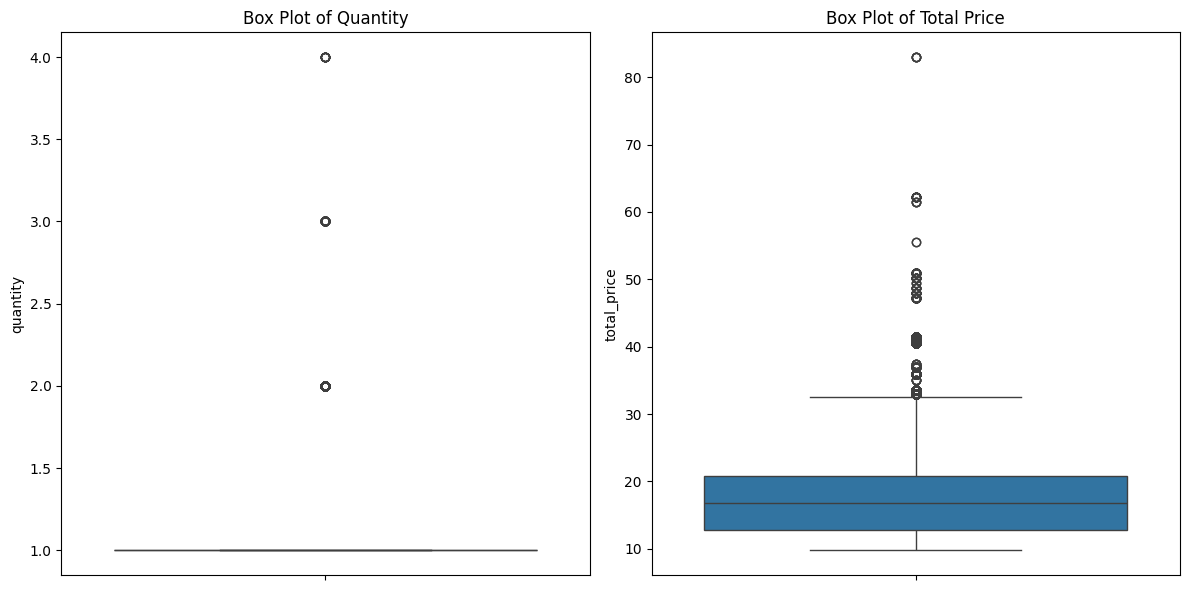

In [54]:
### Check and remove Outliers in Quantity and Total price

# Set up the figure and axes
plt.figure(figsize=(12, 6))

 # Box plot for 'quantity'
plt.subplot(1, 2, 1)
sns.boxplot(data=merged_data, y='quantity')
plt.title('Box Plot of Quantity')

# Box plot for 'total_price'
plt.subplot(1, 2, 2)
sns.boxplot(data=merged_data, y='total_price')
plt.title('Box Plot of Total Price')

plt.tight_layout()
plt.show()

In [55]:
# Apply the function to remove outliers in 'quantity' and 'total_price'
removed_outliers = remove_outliers_iqr(merged_data, 'quantity')
removed_outliers = remove_outliers_iqr(merged_data, 'total_price')

In [56]:
# Find outliers removed from the 'quantity' column
outliers_quantity = merged_data.merge(removed_outliers, on=list(merged_data.columns), how='left', indicator=True)
outliers_quantity = outliers_quantity[outliers_quantity['_merge'] == 'left_only'][['quantity']]
print("Outliers in 'quantity':")
print(outliers_quantity)

Outliers in 'quantity':
        quantity
699            3
700            3
701            3
702            3
703            3
...          ...
187294         2
187295         2
187296         2
187297         2
187298         2

[2495 rows x 1 columns]


In [57]:
# Find outliers removed from the 'total_price' column
outliers_total_price = merged_data.merge(removed_outliers, on=list(merged_data.columns), how='left', indicator=True)
outliers_total_price = outliers_total_price[outliers_total_price['_merge'] == 'left_only'][['total_price']]
print("Outliers in 'total_price':")
print(outliers_total_price)

Outliers in 'total_price':
        total_price
699           62.25
700           62.25
701           62.25
702           62.25
703           62.25
...             ...
187294        41.50
187295        41.50
187296        41.50
187297        41.50
187298        41.50

[2495 rows x 1 columns]


In [58]:
# Update merged_data by keeping only the rows in merged_data_no_outliers
merged_data = removed_outliers.copy()

# Verify the update
print("Updated merged_data shape:", merged_data.shape)

Updated merged_data shape: (184877, 19)


In [59]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184877 entries, 0 to 267573
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pizza_id            184877 non-null  int64         
 1   order_id            184877 non-null  int64         
 2   pizza_name_id       184877 non-null  object        
 3   quantity            184877 non-null  int64         
 4   order_date          184877 non-null  datetime64[ns]
 5   order_time          184877 non-null  object        
 6   unit_price          184877 non-null  float64       
 7   total_price         184877 non-null  float64       
 8   pizza_size          184877 non-null  object        
 9   pizza_category      184877 non-null  object        
 10  pizza_ingredients   184877 non-null  object        
 11  pizza_name          184877 non-null  object        
 12  Items_Qty_In_Grams  184877 non-null  float64       
 13  day_of_week         184877 non-nul

In [60]:
# Get column names with data types
numerical_columns = [col for col in merged_data.columns if merged_data[col].dtype in ['int64', 'float64']]
print("Numerical Columns:")
print(numerical_columns)

categorical_columns = [col for col in merged_data.columns if merged_data[col].dtype == 'object']
print("Categorical Columns:")
print(categorical_columns)

Numerical Columns:
['pizza_id', 'order_id', 'quantity', 'unit_price', 'total_price', 'Items_Qty_In_Grams', 'holiday', 'promotion']
Categorical Columns:
['pizza_name_id', 'order_time', 'pizza_size', 'pizza_category', 'pizza_ingredients', 'pizza_name']


### Statistical Analysis

**Skewness:** Skewness measures the asymmetry of a distribution.

**Kurtosis:** Kurtosis measures the "tailedness" or the extremity of the distribution's tails.

In [61]:
# Calculate statistical measures for all numerical columns
# numerical_columns = merged_data.select_dtypes(include=['float64', 'int64']).columns

# Select specific columns for statistical analysis
selected_columns = ['quantity', 'unit_price', 'total_price']

# Calculate statistics and store in a dictionary
stats = {
    'mean': merged_data[numerical_columns].mean(),
    'median': merged_data[numerical_columns].median(),
    'mode': merged_data[numerical_columns].mode().iloc[0],  # .iloc[0] to handle multiple modes
    'std': merged_data[numerical_columns].std(),
    'var': merged_data[numerical_columns].var()
}

# Statistical summary
stats_df = pd.DataFrame(stats, index=selected_columns)
print("Statistical Summary of Numerical Columns:")
display(stats_df)

# Checking skewness of total_price to interpret distribution shape
if stats_df.loc['total_price', 'mean'] > stats_df.loc['total_price', 'median']:
    print("\nThe 'total_price' distribution is right-skewed (mean > median).")
elif stats_df.loc['total_price', 'mean'] < stats_df.loc['total_price', 'median']:
    print("\nThe 'total_price' distribution is left-skewed (mean < median).")
else:
    print("\nThe 'total_price' distribution is symmetric (mean ≈ median).")

Statistical Summary of Numerical Columns:


,mean,median,mode,std,var
quantity,1.006242,1.00,1.00,0.078760,0.006203
unit_price,16.870757,16.75,20.75,3.538958,12.524221
total_price,16.952418,16.75,20.75,3.609317,13.027169



The 'total_price' distribution is right-skewed (mean > median).


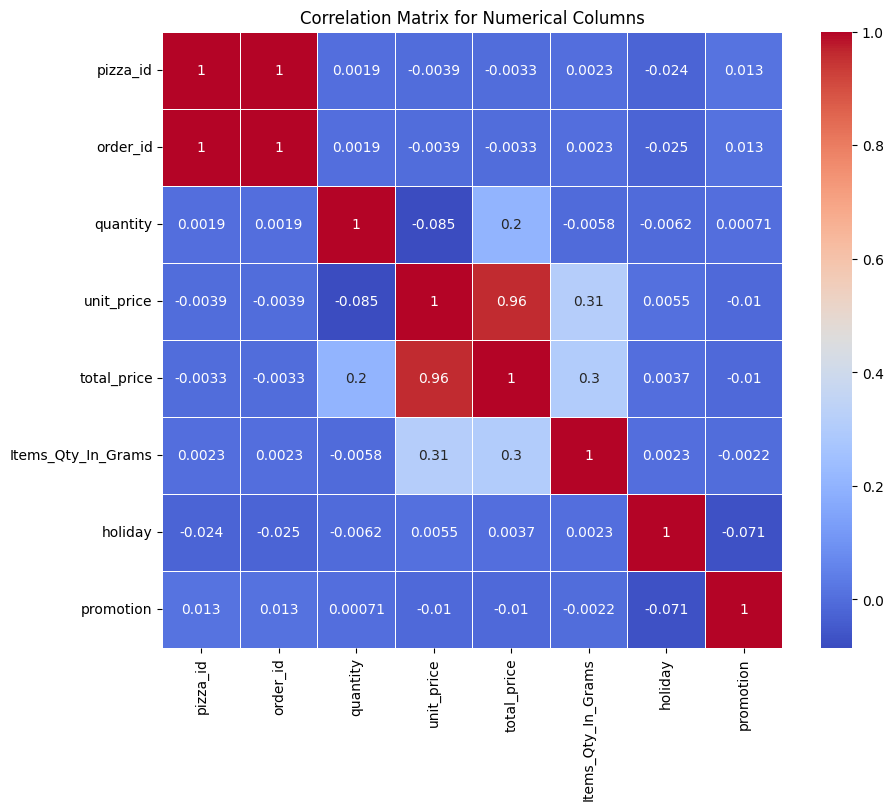

In [62]:
# Select only numerical columns
numerical_df = merged_data.select_dtypes(include=['int64', 'float64'])

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Display the correlation matrix
# print(correlation_matrix)

# Plot the correlation matrix as a heatmap for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix for Numerical Columns")
plt.savefig("eda_results/correlation.png", dpi=300)
plt.show()

## **3. EXPLORATORY DATA ANALYSIS (EDA)**

### i) Analyzing Sales Trends Over Time

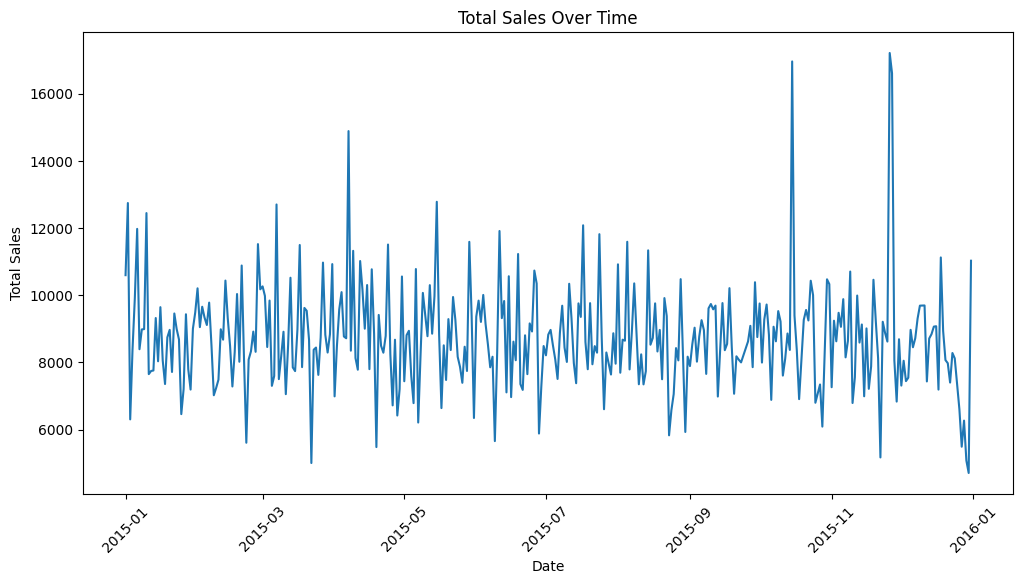

In [63]:
# Ploting sales over time
sales_over_time = merged_data.groupby('order_date')['total_price'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=sales_over_time, x='order_date', y='total_price')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.savefig("eda_results/sales_trend_over_time.png", dpi=300)
plt.show()

### ii) Ploting sales quantity over time

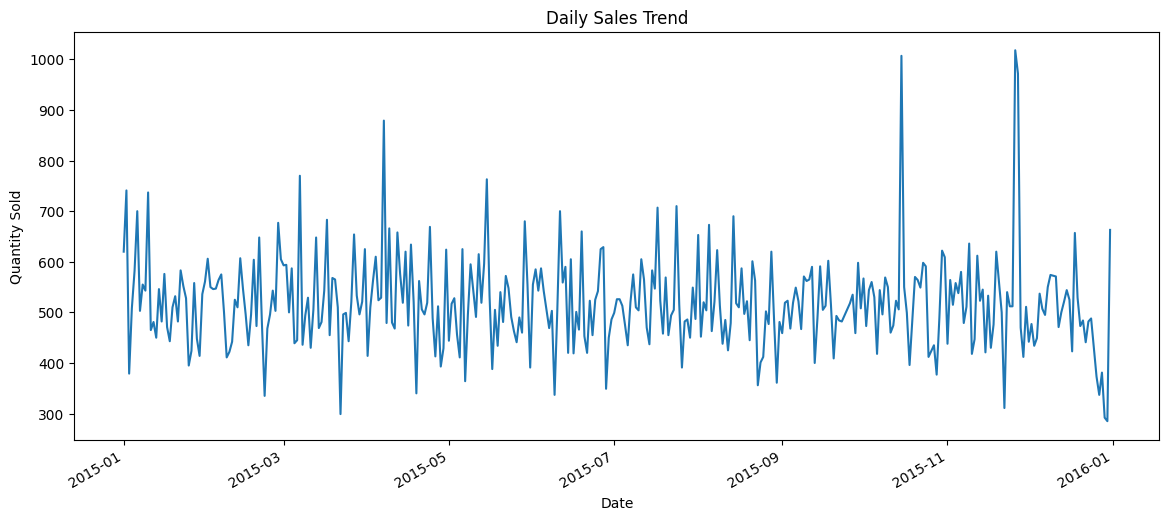

In [64]:
# Group by order date to find daily trends
daily_sales = merged_data.groupby('order_date')['quantity'].sum()
daily_sales.plot(figsize=(14, 6), title='Daily Sales Trend', xlabel='Date', ylabel='Quantity Sold')
plt.savefig("eda_results/sales_quantity_over_time.png", dpi=300)
plt.show()

### iii) Top-Selling Pizzas

Top Selled Pizzas:
                      pizza_name  quantity
4   The California Chicken Pizza     10740
0     The Barbecue Chicken Pizza     10662
25   The Southwest Chicken Pizza      9275
30        The Thai Chicken Pizza      9072
26       The Spicy Italian Pizza      8916


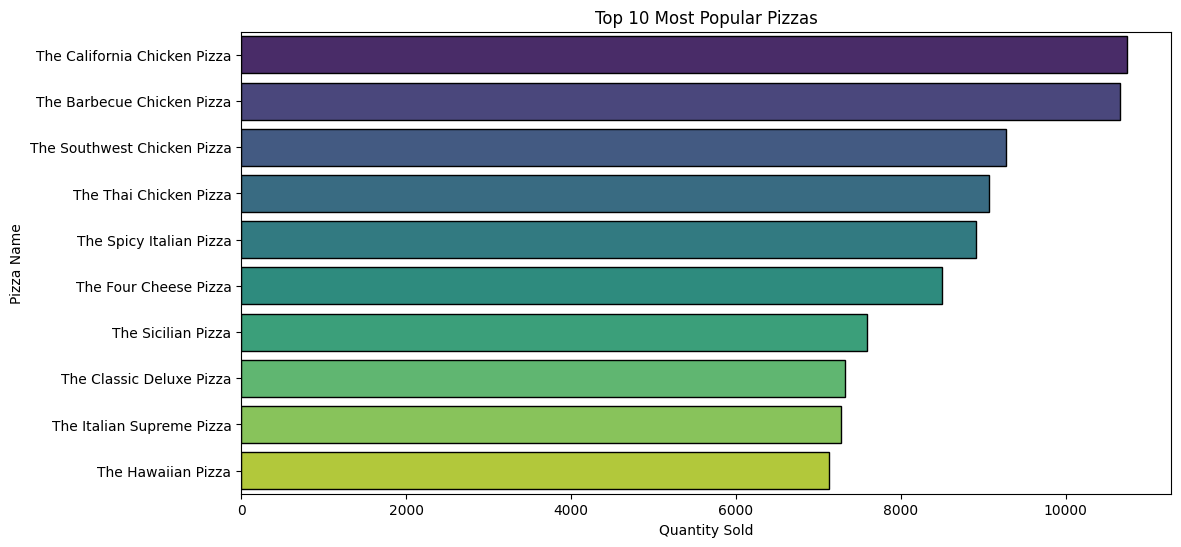

In [65]:
# Aggregate sales by pizza name
top_selled_pizzas = merged_data.groupby('pizza_name')['quantity'].sum().reset_index()

# Sorting by quantity sold
top_selled_pizzas = top_selled_pizzas.sort_values(by='quantity', ascending=False)

# Plotting top 10 most popular pizzas with values on the bars
plt.figure(figsize=(12, 6))
sns.barplot(data=top_selled_pizzas.head(10), x='quantity', y='pizza_name', palette='viridis', edgecolor="black")
plt.title('Top 10 Most Popular Pizzas')
plt.xlabel('Quantity Sold')
plt.ylabel('Pizza Name')
plt.savefig("eda_results/top_selled_pizzas.png", dpi=300)

# Annotate each bar with the quantity sold
# for index, value in enumerate(top_selled_pizzas.head(10)['quantity']):
#     plt.text(value + 20, index, str(value), va='center')
# plt.show()

# Print the output counts
print("Top Selled Pizzas:")
print(top_selled_pizzas.head(5))

### iv) Histogram

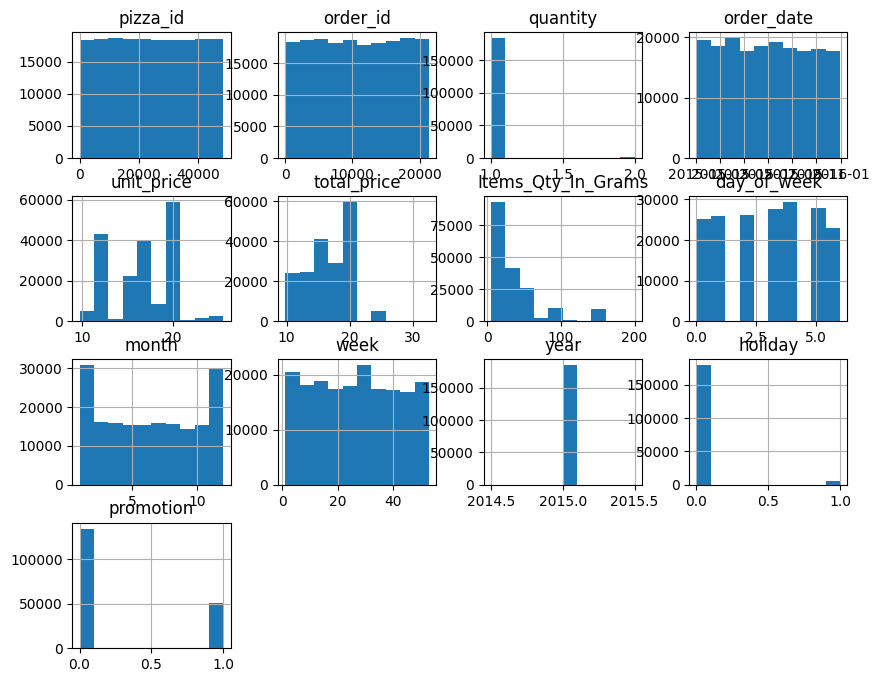

In [66]:
merged_data.hist(figsize=(10,8))
plt.show()

### v) Seasonal Sales Trends (Monthly Sales Patterns)

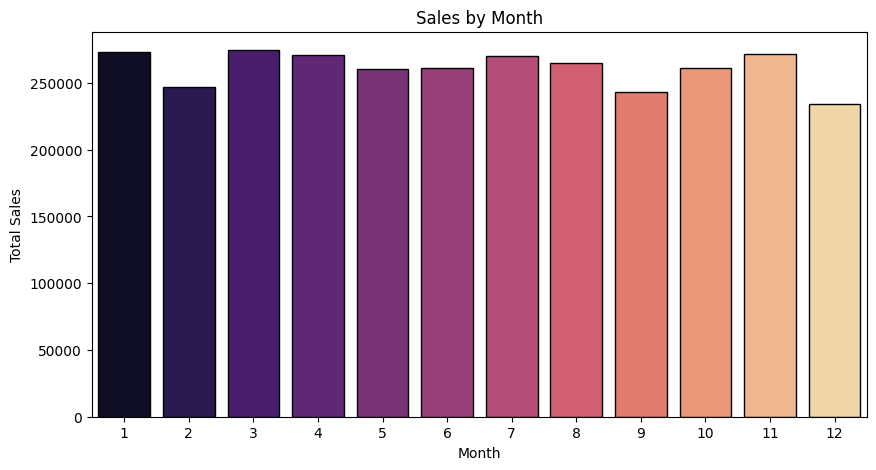

   month  total_price
0      1    273426.45
1      2    246868.40
2      3    274623.55
3      4    270811.85
4      5    260803.90


In [67]:
# Aggregate sales by month
sales_by_month = merged_data.groupby('month')['total_price'].sum().reset_index()

# Plot sales by month
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_month, x='month', y='total_price', palette='magma', edgecolor='black')
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.savefig("eda_results/sales_trend_per_month.png", dpi=300)
plt.show()

print(sales_by_month.head(5))

### vi) Seasonal Sales Trends (Weekly Sales Patterns)

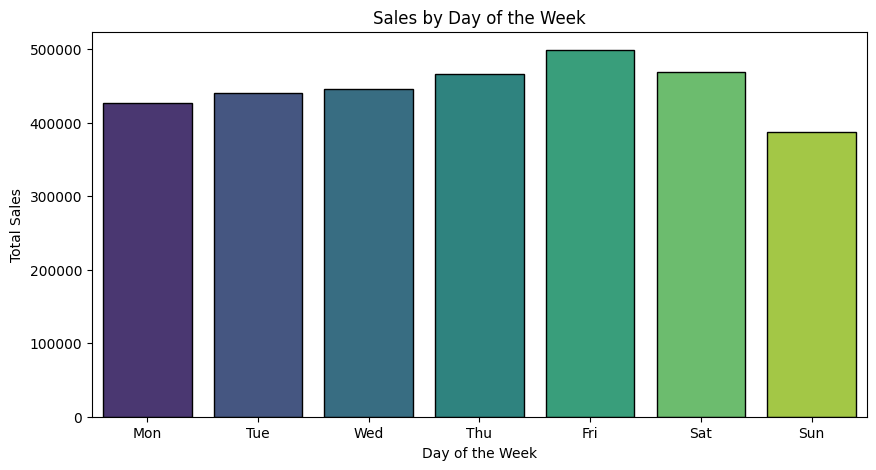

  day_of_week  total_price
0           0    426548.95
1           1    439749.70
2           2    446475.55
3           3    466306.55
4           4    498787.40
5           5    468262.80
6           6    387981.30


In [68]:
# Extract the day of the week as integer (0=Monday, 6=Sunday)
merged_data['day_of_week'] = merged_data['order_date'].dt.dayofweek

# Aggregate sales by day of the week
sales_by_day = merged_data.groupby('day_of_week')['total_price'].sum().reset_index()

# Define order for the days of the week
days_order = [0, 1, 2, 3, 4, 5, 6]
sales_by_day['day_of_week'] = pd.Categorical(sales_by_day['day_of_week'], categories=days_order, ordered=True)

# Plot sales by day of the week
plt.figure(figsize=(10, 5))
sns.barplot(data=sales_by_day, x='day_of_week', y='total_price', palette='viridis', edgecolor='black')
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.savefig("eda_results/sales_trend_per_week.png", dpi=300)
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

# Printing the output for verification
print(sales_by_day)

### vii) Sales by Pizza Size

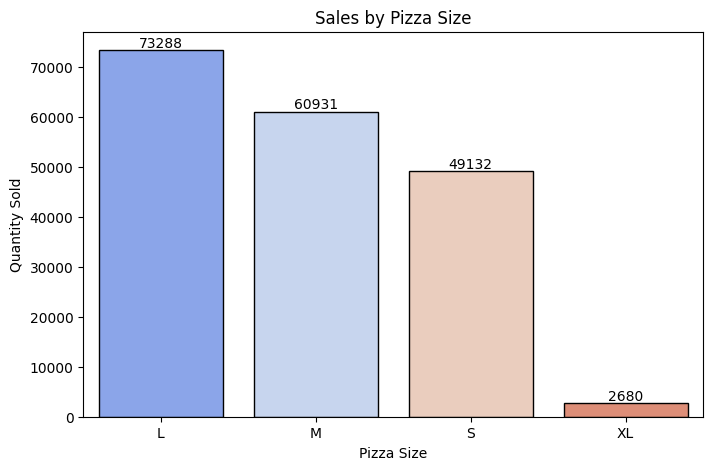

In [69]:
# Aggregate sales by pizza size
size_sales = merged_data.groupby('pizza_size')['quantity'].sum().reset_index()

# Ploting pizza size distribution
plt.figure(figsize=(8, 5))
sns.barplot(data=size_sales, x='pizza_size', y='quantity', palette='coolwarm', edgecolor="black")
plt.title('Sales by Pizza Size')
plt.xlabel('Pizza Size')
plt.ylabel('Quantity Sold')
plt.savefig("eda_results/sales_trend_by_size.png", dpi=300)

# Annotate each bar with the quantity sold
for index, value in enumerate(size_sales['quantity']):
    plt.text(index, value + 0.5, str(value), ha='center', va='bottom')
plt.show()

# Print the output counts
# print("Pizza Sales by size:\n", size_sales)

### viii) Sales by Pizza Category

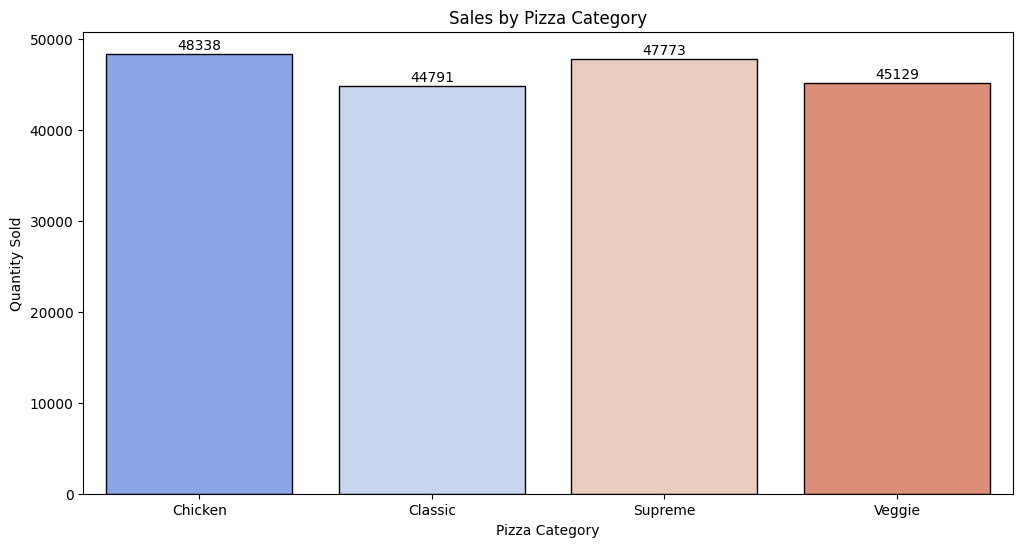

  pizza_category  quantity
0        Chicken     48338
1        Classic     44791
2        Supreme     47773
3         Veggie     45129


In [70]:
# Plotting pizza category distribution
category_sales = merged_data.groupby('pizza_category')['quantity'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=category_sales, x='pizza_category', y='quantity', palette='coolwarm', edgecolor='black')
plt.title('Sales by Pizza Category')
plt.xlabel('Pizza Category')
plt.ylabel('Quantity Sold')
plt.savefig("eda_results/sales_trend_by_category.png", dpi=300)

# Adding quantity labels on top of each bar
for index, row in category_sales.iterrows():
    plt.text(x=index, y=row['quantity']+ 500, s=row['quantity'], ha='center', color='black')
plt.show()

# Printing the output for verification
print(category_sales)

### ix) Sales during holidays vs non-holidays

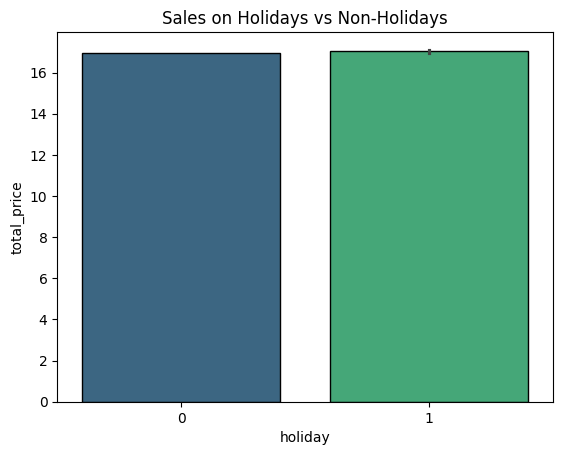

In [71]:
sns.barplot(x='holiday', y='total_price', data=merged_data, palette='viridis', edgecolor='black')
plt.title('Sales on Holidays vs Non-Holidays')
plt.savefig("eda_results/sales_on_holidays.png", dpi=300)
plt.show()

### x) Sales during promotions vs non-promotions

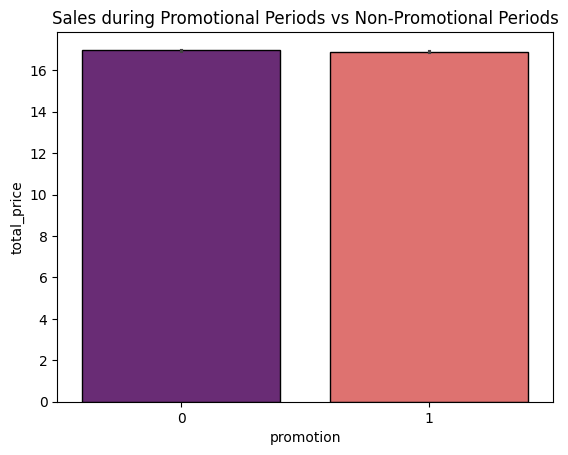

In [72]:
sns.barplot(x='promotion', y='total_price', data=merged_data, palette='magma', edgecolor='black')
plt.title('Sales during Promotional Periods vs Non-Promotional Periods')
plt.savefig("eda_results/sales_trends_by_promotion.png", dpi=300)
plt.show()

## **4. MODELS SELECTION AND TRAINING**

### **i) ARIMA MODEL**

#### **IMPORTANT PARAMETERS NEEDS TUNING TO GET BEST MODEL**

**p (AutoRegressive term):** The number of past observations (lags) used to predict the future value.

**d (Differencing term):** The number of times the data is differenced to make it stationary.

**q (Moving Average term):** The number of past forecast errors used to improve future predictions.

Train data:
order_date
2015-09-14    3622
2015-09-21    2512
2015-09-28    3709
2015-10-05    3567
2015-10-12    3955
Name: quantity, dtype: int64

Test data:
order_date
2015-11-30    3357
2015-12-07    3161
2015-12-14    3672
2015-12-21    2605
2015-12-28    1621
Name: quantity, dtype: int64

Best ARIMA Model MAPE: 19.91% 
Best Parameters: (4, 1, 0)

Predictions:
order_date
2015-10-19    3319.775878
2015-10-26    3375.773486
2015-11-02    3595.293288
2015-11-09    3620.336190
2015-11-16    3575.762606
2015-11-23    3457.865741
2015-11-30    3522.849250
2015-12-07    3567.981969
2015-12-14    3560.283906
2015-12-21    3528.769230
2015-12-28    3519.588191
Name: predicted_mean, dtype: float64


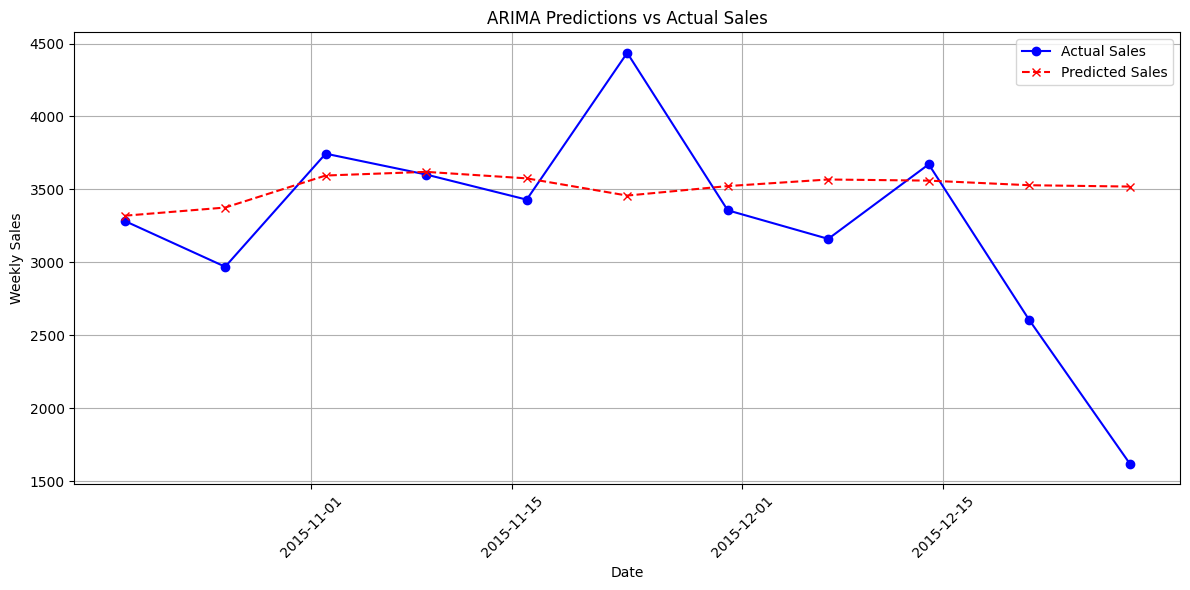

In [73]:
# STEP 1: Prepare Weekly Sales Data
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    # weekly_sales.index = pd.DatetimeIndex(weekly_sales.index, freq='W-MON')  # Explicit frequency
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(merged_data)

# STEP 2: Train-Test Split (Use 80% of the data for training and 20% for testing)
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Display the train and test data to verify the split
print("Train data:")
print(train.tail())
print("\nTest data:")
print(test.tail())

# Step 3: Define MAPE Calculation
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Step 4: ARIMA Model Tuning
import itertools
def tune_arima_model(train, test, p_values, d_values, q_values):
    best_score, best_params, best_predictions = float("inf"), None, None

# Iterate over each combination of p, d, q to find the best ARIMA model
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q)).fit()     # Fit ARIMA model
            predictions = model.forecast(steps=len(test))   # Make predictions on test data
            arima_mape = mape(test, predictions)            # Calculate MAPE
            if arima_mape < best_score:                     # Update best model if MAPE is lower
                best_score, best_params, best_predictions = arima_mape, (p, d, q), predictions
        except:
            continue
    print(f"\nBest ARIMA Model MAPE: {best_score:.2f}%", f"\nBest Parameters: {best_params}")
    return best_predictions, best_score, best_params

# Step 5: Set Parameters and Tune ARIMA Model
p_values, d_values, q_values = range(0, 5), range(0, 2), range(0, 5)
arima_predictions, arima_mape_score, best_params = tune_arima_model(train, test, p_values, d_values, q_values)

# Step 6: Format and Display Predictions
arima_predictions = pd.Series(arima_predictions, index=test.index)
print("\nPredictions:")
print(arima_predictions)

# Step 7: Plot Actual vs Predicted Sales
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(arima_predictions.index, arima_predictions, label='Predicted Sales', color='red', linestyle='--', marker='x')
plt.title('ARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### **ii) SARIMA MODEL (SEASONAL ANALYSIS)**

**P (Seasonal AutoRegressive term):** The number of past seasonal values used for prediction.

**D (Seasonal Differencing term):** The number of seasonal differencing applied to make data stationary.

**Q (Seasonal Moving Average term):** The number of past seasonal forecast errors used for prediction.

**S (Seasonal Period):** The length of the seasonal cycle (e.g., 12 for yearly seasonality in monthly data).

Best SARIMA Model MAPE: 22.46%

Predictions: order_date
2015-10-19    3467.898918
2015-10-26    3821.591976
2015-11-02    3661.079357
2015-11-09    3362.452422
2015-11-16    3588.727411
2015-11-23    3674.144104
2015-11-30    3697.172848
2015-12-07    3579.600503
2015-12-14    3859.365867
2015-12-21    3712.910737
2015-12-28    3421.524092
Name: predicted_mean, dtype: float64


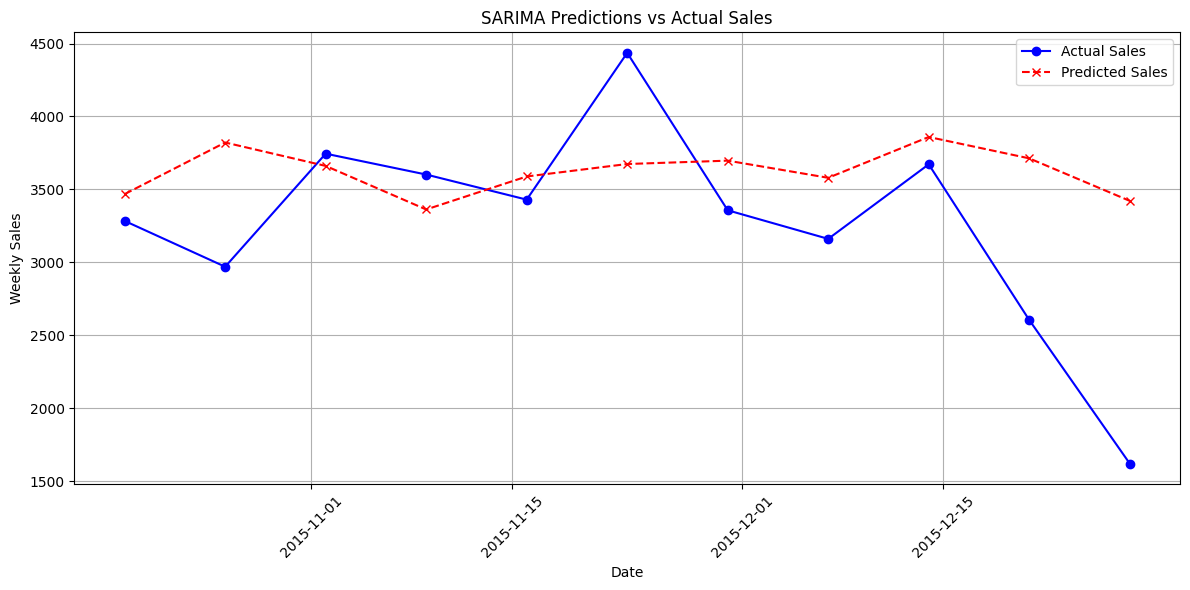

In [74]:
# STEP 1: Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(merged_data)

# STEP 2: Train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# STEP 3: Evaluate MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# STEP 4: SARIMA Model Training
def best_sarima_model(train, test):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)
    predictions = model.forecast(steps=len(test))
    sarima_mape = mape(test, predictions)
    print(f"Best SARIMA Model MAPE: {sarima_mape:.2f}%")
    return predictions, sarima_mape

# STEP 5: Train, Evaluate the SARIMA model
sarima_predictions, sarima_mape_score = best_sarima_model(train, test)
sarima_predictions = pd.Series(sarima_predictions, index=test.index)
print("\nPredictions:", sarima_predictions)

# STEP 6: Plotting Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(sarima_predictions.index, sarima_predictions, label='Predicted Sales', color='red', linestyle='--', marker='x')
plt.title('SARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### **iii) PROPHET MODEL (Developed by Facebook)**

#### Prophet is a popular model for handling time series data with seasonal and holiday effects.
The Facebook Prophet model is a tool developed by Facebook for forecasting time series data. It’s especially useful when you want to predict future values based on historical data, such as sales, temperatures, or website traffic.
* Growth: Defines the trend type (linear or logistic).
* Changepoints: Points where the trend changes.
* Seasonality: Models seasonal patterns (weekly, yearly, etc.).
* Holidays: Incorporates custom holidays or events affecting the forecast.
* Seasonality Mode: Can be additive or multiplicative.

10:45:52 - cmdstanpy - INFO - Chain [1] start processing
10:45:52 - cmdstanpy - INFO - Chain [1] done processing



Best Prophet Model MAPE: 21.74%

Predictions:
ds
2015-10-19    3579.692320
2015-10-26    3579.909002
2015-11-02    3580.125684
2015-11-09    3580.342366
2015-11-16    3580.559048
2015-11-23    3580.775729
2015-11-30    3580.992411
2015-12-07    3581.209093
2015-12-14    3581.425775
2015-12-21    3581.642457
2015-12-28    3581.859139
dtype: float64


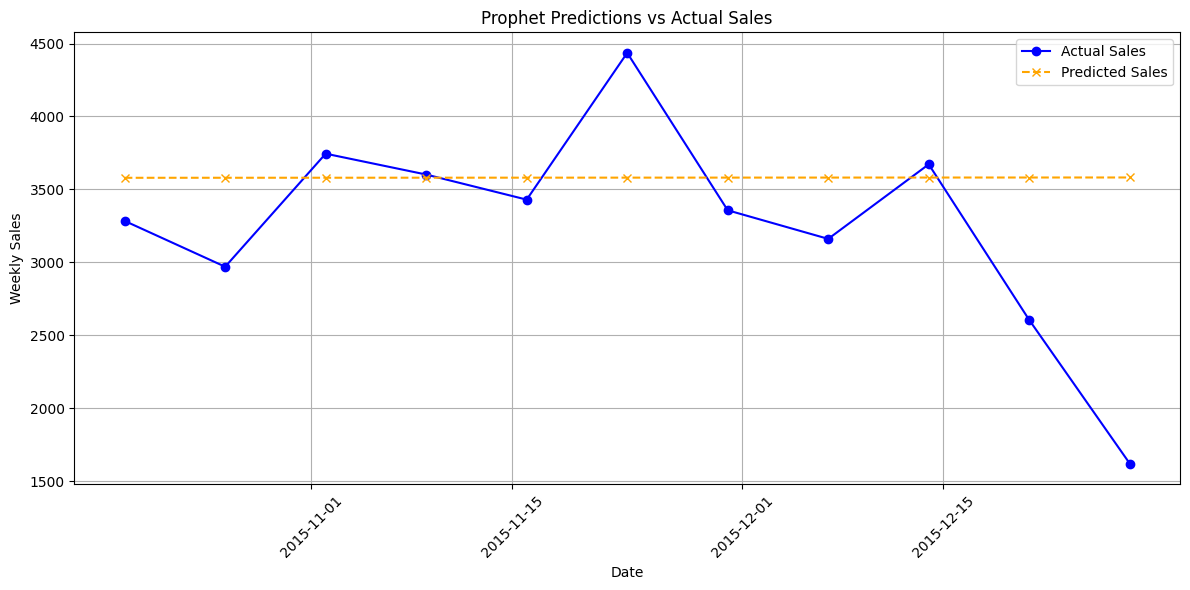

In [75]:
# STEP 1: Prepare Data for Prophet
# Rename columns to match Prophet's expected format
df = merged_data.rename(columns={'order_date': 'ds', 'quantity': 'y'})  # Adssign variable name as ds (train_feature)and y (target))
df = df[['ds', 'y']]

# STEP 2: Pizza sales by week
def prepare_weekly_sales_for_prophet(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    weekly_sales.columns = ['ds', 'y']  # Prophet requires columns 'ds' for date and 'y' for the target variable
    return weekly_sales
pizza_sales_weekly = prepare_weekly_sales_for_prophet(merged_data)

# STEP 3: Train Test Split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# STEP 4: Evaluate MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual) * 100)

# STEP 5: Initialize and train the model
def best_prophet_model(train, test):
    model = Prophet()
    model.fit(train)

    # Create a DataFrame with future dates for predictions
    future = model.make_future_dataframe(periods=len(test), freq='W')

    # Generate predictions for future dates
    forecast = model.predict(future)
    
    # Extract the predictions for the test period
    predictions = forecast['yhat'][-len(test):].values
    
    # Calculate MAPE
    prophet_mape = mape(test['y'].values, predictions)
    print(f"\nBest Prophet Model MAPE: {prophet_mape:.2f}%")
    return predictions, prophet_mape

# Train and evaluate the Prophet model
prophet_predictions, prophet_mape_score = best_prophet_model(train, test)

# Formating the predictions for display
prophet_predictions = pd.Series(prophet_predictions, index=test['ds'])

print("\nPredictions:")
print(prophet_predictions)

# STEP 6:  Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='Actual Sales', color='blue', marker='o')
plt.plot(prophet_predictions.index, prophet_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('Prophet Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### **iv) REGRESSION MODEL**

Best Regression Model MAPE: 19.20%

Predictions:
start_of_week
2015-10-19    3495.667443
2015-10-26    3441.427560
2015-11-02    3605.441068
2015-11-09    3551.201185
2015-11-16    3496.961302
2015-11-23    3442.721419
2015-11-30    3388.481536
2015-12-07    3552.495044
2015-12-14    3498.255161
2015-12-21    3444.015278
2015-12-28    3389.775394
dtype: float64


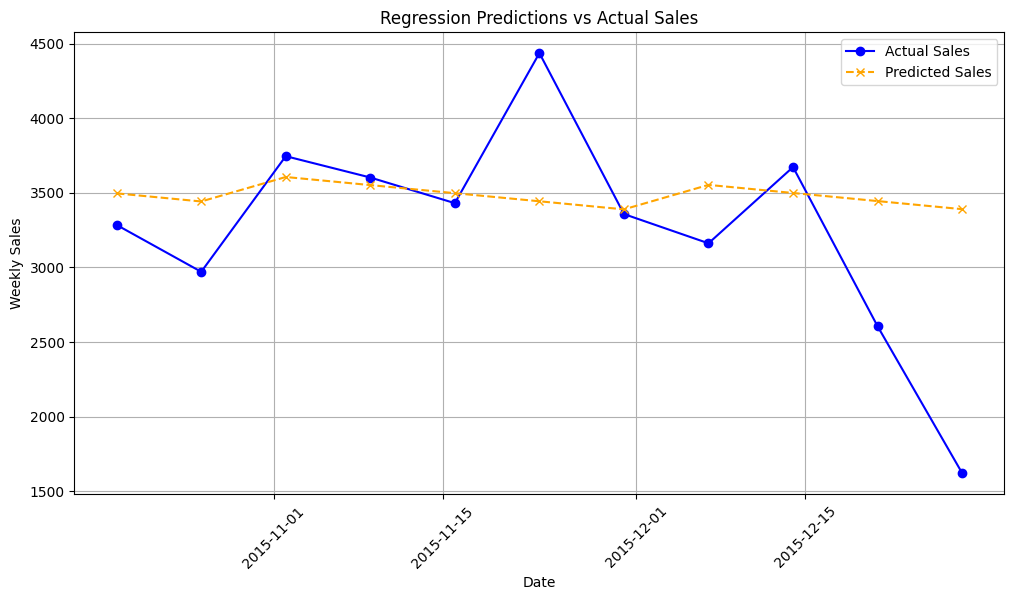

In [76]:
# STEP 1: Aggregate Weekly Sales
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    weekly_sales.rename(columns={'order_date': 'start_of_week'}, inplace=True)
    return weekly_sales

# STEP 2: Feature Engineering
def create_regression_features(df):
    df['week_of_year'] = df['start_of_week'].dt.isocalendar().week
    df['day_of_week'] = df['start_of_week'].dt.weekday
    df['month'] = df['start_of_week'].dt.month
    df['year'] = df['start_of_week'].dt.year
    return df

# MAPE Function
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# STEP 3: Prepare Weekly Sales and Feature Engineering
pizza_sales_weekly = prepare_weekly_sales(merged_data)
pizza_sales_weekly = create_regression_features(pizza_sales_weekly)

# STEP 4: Train-Test Split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

X_train = train[['week_of_year', 'day_of_week', 'month', 'year']]
y_train = train['quantity']
X_test = test[['week_of_year', 'day_of_week', 'month', 'year']]
y_test = test['quantity']

# STEP 5: Define Regression Model and Evaluate
def best_regression_model(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    regression_mape = mape(y_test, predictions)
    print(f"Best Regression Model MAPE: {regression_mape:.2f}%")
    return predictions, regression_mape

# Evaluate Regression Model
regression_predictions, regression_mape_score = best_regression_model(X_train, y_train, X_test, y_test)

# Format Predictions
regression_predictions = pd.Series(regression_predictions, index=test['start_of_week'])

print("\nPredictions:")
print(regression_predictions)

# STEP 6: Plot Actual vs Predicted Sales
plt.figure(figsize=(12, 6))
plt.plot(test['start_of_week'], y_test, label='Actual Sales', color='blue', marker='o')
plt.plot(regression_predictions.index, regression_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('Regression Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

### **v) LSTM MODEL**

1/1 [==============================] - 0s 149ms/step
Best LSTM Model MAPE: 23.71%

Predictions:
order_date
2015-11-09    3409.177979
2015-11-16    3462.427002
2015-11-23    3585.941650
2015-11-30    3685.864990
2015-12-07    3667.296875
2015-12-14    3668.926270
2015-12-21    3448.224854
2015-12-28    3338.598633
dtype: float32


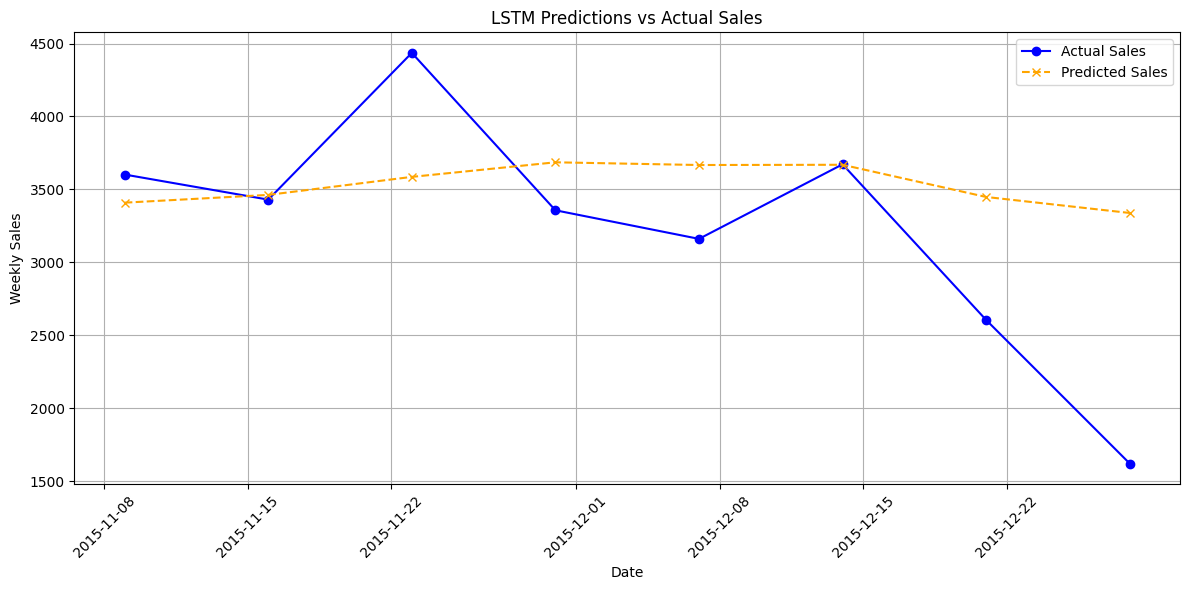

In [77]:
# STEP 1: Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    return weekly_sales
pizza_sales_weekly = prepare_weekly_sales(merged_data)

# STEP 2: Train Test Split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# STEP 3: Normalizeing the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['quantity']])
test_scaled = scaler.transform(test[['quantity']])

# STEP 4: Preparing data for LSTM
def create_lstm_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 3
X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

# STEP 5: Reshapeing X for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# STEP 6: Train LSTM Model
def best_lstm_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    lstm_mape = mape(y_test_rescaled, predictions)
    print(f"Best LSTM Model MAPE: {lstm_mape:.2f}%")
    return predictions, lstm_mape, y_test_rescaled

# STEP 7: Train and evaluate LSTM model
lstm_predictions, lstm_mape_score, y_test_rescaled = best_lstm_model(X_train, y_train, X_test, y_test)

# Formatting the predictions for display
lstm_predictions = pd.Series(lstm_predictions.flatten(), index=test['order_date'][time_steps:])

print("\nPredictions:")
print(lstm_predictions)

# STEP 8: Plot the Actual Vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'][time_steps:], y_test_rescaled, label='Actual Sales', color='blue', marker='o')
plt.plot(lstm_predictions.index, lstm_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('LSTM Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### **Performance comaprison of models**

In [78]:
# Model results as a dictionary
model_performance = {
    'Model': ['ARIMA', 'SARIMA', 'Prophet', 'Regression', 'LSTM'],
    'MAPE': [0.1932, 0.1846, 0.2174, 0.1920, 0.2371]
}

# Createing a DataFrame
df_performance = pd.DataFrame(model_performance)

# Highlight best and worst models
df_performance['Rank'] = df_performance['MAPE'].rank()
df_performance = df_performance.sort_values('MAPE', ascending=True)
df_performance['Best/Worst'] = df_performance['MAPE'].apply(lambda x: 'Best' if x == df_performance['MAPE'].min() else 'Worst' if x == df_performance['MAPE'].max() else '')

# Display table
df_performance

,Model,MAPE,Rank,Best/Worst
1,SARIMA,0.1846,1.0,Best
3,Regression,0.1920,2.0,
0,ARIMA,0.1932,3.0,
2,Prophet,0.2174,4.0,
4,LSTM,0.2371,5.0,Worst


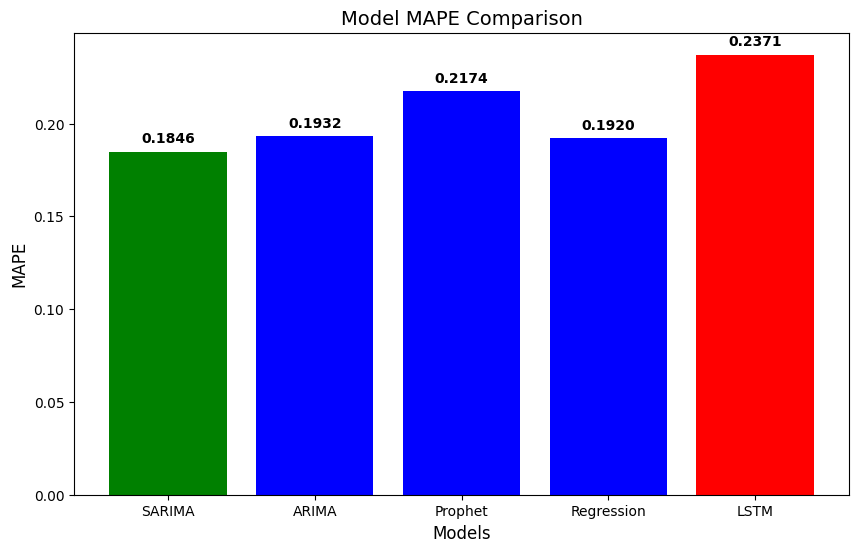

In [81]:
# Visualization of performance level of Models
import matplotlib.pyplot as plt
# Data for plotting
models = ['SARIMA', 'ARIMA', 'Prophet', 'Regression', 'LSTM']
mapes = [0.1846, 0.1932, 0.2174, 0.1920, 0.2371]

plt.figure(figsize=(10,6))
plt.bar(models, mapes, color=['green', 'blue', 'blue', 'blue', 'red'])

# Highlighting the best and worst models
plt.title('Model MAPE Comparison', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('MAPE', fontsize=12)

for i, v in enumerate(mapes):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

### Based on the performance comparison, SARIMA demonstrated the lowest MAPE value, indicating it is the most suitable model. It can be effectively applied for weekly sales prediction, ingredients estimation, and purchase order creation.

In [82]:
# Data preparation
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load data
Sales_df = pd.read_excel("data/Pizza_Sale.xlsx")
Ingredients_df = pd.read_excel("data/Pizza_ingredients.xlsx")

In [83]:
Sales_df.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01 00:00:00,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01 00:00:00,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [84]:
Sales_df.isnull().sum()

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64

In [85]:
# Drop any rows with missing values in sales data

Sales_df.dropna(inplace=True)

In [86]:
Sales_df.isnull().sum()

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

In [87]:
Sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48554 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48554 non-null  int64  
 1   order_id           48554 non-null  int64  
 2   pizza_name_id      48554 non-null  object 
 3   quantity           48554 non-null  int64  
 4   order_date         48554 non-null  object 
 5   order_time         48554 non-null  object 
 6   unit_price         48554 non-null  float64
 7   total_price        48554 non-null  float64
 8   pizza_size         48554 non-null  object 
 9   pizza_category     48554 non-null  object 
 10  pizza_ingredients  48554 non-null  object 
 11  pizza_name         48554 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.8+ MB


In [88]:
# Convert order_date to datetime format

def parse_dates(date):
    for fmt in ('%d-%m-%Y', '%d/%m/%Y'):
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            pass
    raise ValueError(f'No valid date format found for {date}')
Sales_df['order_date'] = Sales_df['order_date'].apply(parse_dates)

In [89]:
# Prepare data for weekly aggregation
Sales_df = Sales_df[['order_date', 'pizza_name', 'quantity']]
sales_summary = Sales_df.groupby(['order_date', 'pizza_name']).sum().reset_index()

# Pivot the data to have pizza names as columns
sales_pivot = sales_summary.pivot(index='order_date', columns='pizza_name', values='quantity').fillna(0)

In [90]:
sales_pivot.head()

pizza_name,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
order_date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,11.0,5.0,0.0,1.0,4.0,2.0,4.0,10.0,6.0,5.0,...,4.0,4.0,0.0,7.0,5.0,2.0,5.0,2.0,7.0,3.0
2015-01-02,12.0,9.0,3.0,7.0,15.0,3.0,2.0,13.0,5.0,6.0,...,6.0,5.0,3.0,9.0,9.0,5.0,3.0,4.0,8.0,1.0
2015-01-03,2.0,3.0,1.0,1.0,6.0,0.0,1.0,4.0,5.0,4.0,...,1.0,2.0,0.0,9.0,4.0,3.0,0.0,5.0,4.0,6.0
2015-01-04,2.0,3.0,0.0,2.0,3.0,3.0,2.0,8.0,7.0,6.0,...,4.0,8.0,6.0,10.0,4.0,4.0,6.0,1.0,3.0,5.0
2015-01-05,6.0,1.0,1.0,4.0,11.0,2.0,5.0,9.0,6.0,4.0,...,5.0,5.0,0.0,6.0,5.0,2.0,4.0,5.0,10.0,6.0


In [91]:
sales_summary.head()

,order_date,pizza_name,quantity
0,2015-01-01,The Barbecue Chicken Pizza,11
1,2015-01-01,The Big Meat Pizza,5
2,2015-01-01,The Calabrese Pizza,1
3,2015-01-01,The California Chicken Pizza,4
4,2015-01-01,The Chicken Alfredo Pizza,2


In [92]:
Sales_df.tail()

,order_date,pizza_name,quantity
48615,2015-12-31,The Chicken Alfredo Pizza,1
48616,2015-12-31,The Four Cheese Pizza,1
48617,2015-12-31,The Napolitana Pizza,1
48618,2015-12-31,The Mexicana Pizza,1
48619,2015-12-31,The Barbecue Chicken Pizza,1


In [93]:
# Applying SARIMA Model for Forecasting

# Initialize a dictionary to store SARIMA models for each pizza
sarima_models = {}

# Fit the SARIMA model for each pizza type
for pizza_name in sales_pivot.columns:
    try:
        model = SARIMAX(sales_pivot[pizza_name], order=(1, 1, 0), seasonal_order=(1, 1, 0, 7))
        model_fit = model.fit(disp=False)
        sarima_models[pizza_name] = model_fit
    except:
        print(f"SARIMA model for {pizza_name} failed to fit")

In [94]:
# Generate Sales Forecast for Next Week
# Using the trained SARIMA model, forecast pizza sales for the next week (7 days).

prediction_days = 7

predictions_sarima = {}

# Generate forecast for the next 7 days for each pizza type
for pizza_name, model in sarima_models.items():
    predictions_sarima[pizza_name] = model.predict(start=len(sales_pivot), end=len(sales_pivot) + prediction_days - 1)

# Convert the predictions into a DataFrame
predictions_df = pd.DataFrame(predictions_sarima)

# Assign dates for the forecasted period
predictions_df.index = pd.date_range(start=sales_pivot.index[-1], periods=prediction_days, freq='D')

In [95]:
predictions_df.head()

,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
2015-12-31,8.162552,3.022153,0.190764,2.268178,6.500474,2.196397,3.389738,7.393368,3.951026,7.713858,...,4.548534,0.641035,1.733941,4.809304,2.358156,4.883591,2.546423,3.048892,5.350179,7.437561
2016-01-01,7.781061,7.399277,0.866107,3.374618,6.499686,3.059459,4.267490,7.561603,3.631700,11.749865,...,5.291437,0.796601,2.982279,4.838936,5.219970,5.167511,3.994205,2.523522,8.235083,7.408238
2016-01-02,7.292133,4.196417,1.005412,2.077624,6.499609,1.075890,2.997033,7.445395,3.185665,11.063486,...,2.818090,2.332862,1.998313,3.318275,5.082878,5.602964,1.526124,1.943311,6.406321,10.577717
2016-01-03,9.575023,3.556990,0.129832,1.223214,6.500275,2.946140,4.886369,8.677715,2.042916,7.685246,...,5.803749,-0.923861,2.848069,3.357299,2.476458,3.524517,3.015953,4.206094,3.744689,7.307964
2016-01-04,8.611897,5.332825,0.561154,3.652895,6.500571,2.645417,1.682049,6.206635,2.458055,8.651651,...,3.673067,-0.221436,2.978409,4.295568,2.977160,4.826805,1.015247,1.588337,4.834786,5.279084


In [96]:
ingredients_df = Ingredients_df[['pizza_name', 'pizza_ingredients', 'Items_Qty_In_Grams']]

# change column name to items_qty
ingredients_df.rename(columns={'Items_Qty_In_Grams': 'items_qty'}, inplace=True)

In [97]:
ingredients_df

,pizza_name,pizza_ingredients,items_qty
0,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,The Barbecue Chicken Pizza,Red Peppers,15.0
2,The Barbecue Chicken Pizza,Green Peppers,20.0
3,The Barbecue Chicken Pizza,Tomatoes,30.0
4,The Barbecue Chicken Pizza,Red Onions,60.0
...,...,...,...
513,The Vegetables + Vegetables Pizza,Green Peppers,20.0
514,The Vegetables + Vegetables Pizza,Red Onions,20.0
515,The Vegetables + Vegetables Pizza,Zucchini,10.0
516,The Vegetables + Vegetables Pizza,Spinach,15.0


### **Calculating the quantities of ingredients required for the predicted pizza sales**

In [98]:
# Create a dictionary to store ingredient quantities

ingredient_quantities = {}

# Get the ingredients for the pizza
for pizza_name in predictions_df.columns:
    predicted_quantity = predictions_df[pizza_name].sum()
    pizza_ingredients = ingredients_df[ingredients_df['pizza_name'] == pizza_name]
    
    for index, row in pizza_ingredients.iterrows():
        ingredient = row['pizza_ingredients']
        ingredient_qty = row['items_qty']
        required_quantity = predicted_quantity * ingredient_qty
        
        # Add to the dictionary
        if ingredient in ingredient_quantities:
            ingredient_quantities[ingredient] += required_quantity
        else:
            ingredient_quantities[ingredient] = required_quantity

In [99]:
# Create a DataFrame from the ingredient quantities
ingredient_requirements_df = pd.DataFrame.from_dict(ingredient_quantities, orient='index', columns=['required_quantity'])
ingredient_requirements_df

,required_quantity
Barbecued Chicken,5555.640361
Red Peppers,11191.550429
Green Peppers,7683.655622
Tomatoes,29911.915727
Red Onions,44897.896934
...,...
Luganega Sausage,444.243119
Onions,222.121559
Soppressata Salami,5296.160247
Peperoncini verdi,910.709135


In [100]:
# Determine the last date in historical data
last_date = sales_pivot.index[-1]

# Generate date range for predictions
prediction_days = 7  # Number of days to predict
predicted_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=prediction_days, freq='D')

# Assign predicted dates to predictions DataFrame
predictions_df.index = predicted_dates
predictions_df

,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
2016-01-01,8.162552,3.022153,0.190764,2.268178,6.500474,2.196397,3.389738,7.393368,3.951026,7.713858,...,4.548534,0.641035,1.733941,4.809304,2.358156,4.883591,2.546423,3.048892,5.350179,7.437561
2016-01-02,7.781061,7.399277,0.866107,3.374618,6.499686,3.059459,4.267490,7.561603,3.631700,11.749865,...,5.291437,0.796601,2.982279,4.838936,5.219970,5.167511,3.994205,2.523522,8.235083,7.408238
2016-01-03,7.292133,4.196417,1.005412,2.077624,6.499609,1.075890,2.997033,7.445395,3.185665,11.063486,...,2.818090,2.332862,1.998313,3.318275,5.082878,5.602964,1.526124,1.943311,6.406321,10.577717
2016-01-04,9.575023,3.556990,0.129832,1.223214,6.500275,2.946140,4.886369,8.677715,2.042916,7.685246,...,5.803749,-0.923861,2.848069,3.357299,2.476458,3.524517,3.015953,4.206094,3.744689,7.307964
2016-01-05,8.611897,5.332825,0.561154,3.652895,6.500571,2.645417,1.682049,6.206635,2.458055,8.651651,...,3.673067,-0.221436,2.978409,4.295568,2.977160,4.826805,1.015247,1.588337,4.834786,5.279084
2016-01-06,8.574168,5.074458,-0.378368,1.688557,7.000737,2.738058,2.341016,5.180927,2.363094,11.335570,...,3.162750,-2.232781,2.115927,6.368973,4.471047,4.722972,2.038780,1.655954,3.347346,7.517579
2016-01-07,11.732504,5.373256,1.589576,2.167527,6.001046,3.519323,3.658955,9.071744,4.948920,8.603855,...,5.284635,3.309605,2.996928,5.840971,7.771303,5.227202,1.550196,4.168280,3.869727,11.625989


In [101]:
# Create a purchase order DataFrame
purchase_order_df = ingredient_requirements_df.copy()

# Add a column for the unit of measure (assuming all ingredients are in grams)
purchase_order_df['unit'] = 'grams'

# Rename the columns for better readability
purchase_order_df = purchase_order_df.rename(columns={'required_quantity': 'quantity'})

# Add a header to the purchase order
print('Purchase Order:')
# print('----------------')

# Print the purchase order table
print(purchase_order_df.to_string())

Purchase Order:
                                quantity   unit
Barbecued Chicken            5555.640361  grams
Red Peppers                 11191.550429  grams
Green Peppers                7683.655622  grams
Tomatoes                    29911.915727  grams
Red Onions                  44897.896934  grams
Barbecue Sauce               1851.880120  grams
Bacon                       19008.400569  grams
Pepperoni                   22475.053462  grams
Italian Sausage               339.553764  grams
Chorizo Sausage              1697.768818  grams
Brie Carre Cheese             118.934292  grams
Prosciutto                    118.934292  grams
Caramelized Onions                   NaN  grams
Pears                          39.644764  grams
Thyme                          19.822382  grams
Garlic                      15412.604899  grams
?duja Salami                 1974.313619  grams
Pancetta                     2961.470428  grams
Friggitello Peppers           493.578405  grams
Chicken                 